<h1>Diamond Dataset Analysis with PyTorch</h1>

In [33]:
# Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

<h2>Load diamond data</h2>

In [34]:
# Import data
df = pd.read_csv('diamonds.csv')
diamonds = df.copy()

# Remove rows with dimensions of '0'
diamonds = diamonds[(diamonds[['x','y','z']] != 0).all(axis=1)]

# Create new column called Volume
diamonds['volume'] = diamonds['x']*diamonds['y']*diamonds['z']

In [35]:
# Read in the dataset
df = pd.read_csv('diamonds.csv')
df.head()

Unnamed: 0  carat      cut color clarity  depth  table  price     x     y  \
0           1   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98   
1           2   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84   
2           3   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07   
3           4   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23   
4           5   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35   

      z  
0  2.43  
1  2.31  
2  2.31  
3  2.63  
4  2.75

In [36]:
# Drop the index column
df = df.drop('Unnamed: 0', axis=1)

<h2>Preprocess dataset</h2>

In [37]:
# Check for nulls
df.isnull().sum()

# Drop null values
df = df.dropna()

# Drop NaN values
df = df.dropna()

# Check datatypes
df.dtypes

# Display datatypes
display(df.dtypes)

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [38]:
# Verify nulls have been removed
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [39]:
# Check the number of nonzero values in each column
df.astype(bool).sum(axis=0)

carat      53940
cut        53940
color      53940
clarity    53940
depth      53940
table      53940
price      53940
x          53932
y          53933
z          53920
dtype: int64

In [40]:
# Count the number of unique values in each column
df.nunique()

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

<h2>Visualization for dataset</h2>

<h3>Bar Chart for diamond cut, color and clarity</3>

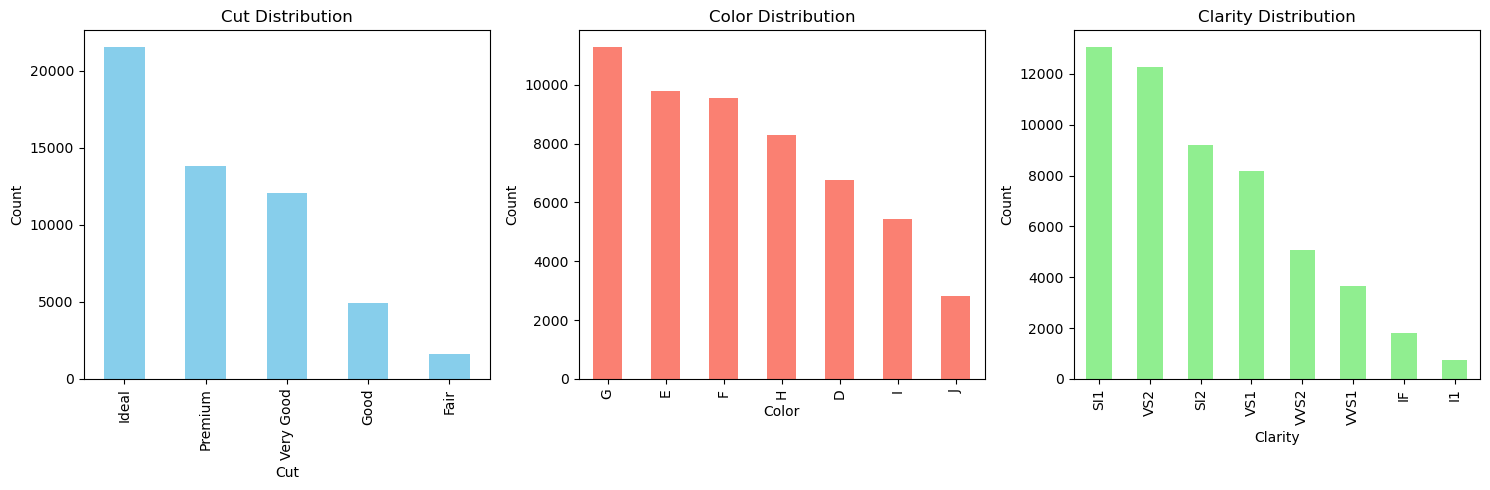

In [41]:
# Define data for visualization
cut_counts = df['cut'].value_counts()
color_counts = df['color'].value_counts()
clarity_counts = df['clarity'].value_counts()

# Create subplots for each feature
plt.figure(figsize=(15, 5))

# Bar plot for cut
plt.subplot(1, 3, 1)
cut_counts.plot(kind='bar', color='skyblue')
plt.title('Cut Distribution')
plt.xlabel('Cut')
plt.ylabel('Count')

# Bar plot for color
plt.subplot(1, 3, 2)
color_counts.plot(kind='bar', color='salmon')
plt.title('Color Distribution')
plt.xlabel('Color')
plt.ylabel('Count')

# Bar plot for clarity
plt.subplot(1, 3, 3)
clarity_counts.plot(kind='bar', color='lightgreen')
plt.title('Clarity Distribution')
plt.xlabel('Clarity')
plt.ylabel('Count')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

<h3>Box chart for diamond price vs. cut, color, clarity</h3>

In [42]:
# Define custom colors
custom_colors = ['skyblue', 'lightgreen', 'salmon', 'lightorange', 'lavender']

# Create box plots for price vs. cut, price vs. color, and price vs. clarity
fig_cut1 = px.box(df, x='cut', y='price', color='cut', title='Price vs. Cut')
fig_color1 = px.box(df, x='color', y='price', color='color', title='Price vs. Color')
fig_clarity1 = px.box(df, x='clarity', y='price', color='clarity', title='Price vs. Clarity')

# Show the box plots
fig_cut1.show()
fig_color1.show()
fig_clarity1.show() 

<h2>Encoding diamond cut, color, and clarity</h2>

In [43]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to columns cut, color and clarity
df['cut'] = label_encoder.fit_transform(df['cut'])
df['color'] = label_encoder.fit_transform(df['color'])
df['clarity'] = label_encoder.fit_transform(df['clarity'])

# Display the first 5 rows of the dataframe
df.head()

carat  cut  color  clarity  depth  table  price     x     y     z
0   0.23    2      1        3   61.5   55.0    326  3.95  3.98  2.43
1   0.21    3      1        2   59.8   61.0    326  3.89  3.84  2.31
2   0.23    1      1        4   56.9   65.0    327  4.05  4.07  2.31
3   0.29    3      5        5   62.4   58.0    334  4.20  4.23  2.63
4   0.31    1      6        3   63.3   58.0    335  4.34  4.35  2.75

<h1>PyTorch</h1>

<h3>Transform data into a tensor object</h3>

In [46]:
tensor_from_df = torch.tensor(df.values)

print(tensor_from_df)

tensor([[0.2300, 2.0000, 1.0000,  ..., 3.9500, 3.9800, 2.4300],
        [0.2100, 3.0000, 1.0000,  ..., 3.8900, 3.8400, 2.3100],
        [0.2300, 1.0000, 1.0000,  ..., 4.0500, 4.0700, 2.3100],
        ...,
        [0.7000, 4.0000, 0.0000,  ..., 5.6600, 5.6800, 3.5600],
        [0.8600, 3.0000, 4.0000,  ..., 6.1500, 6.1200, 3.7400],
        [0.7500, 2.0000, 0.0000,  ..., 5.8300, 5.8700, 3.6400]],
       dtype=torch.float64)


<h3>Define a neural network</h3>

In [47]:
class DiamondsModel(nn.Module): # Inherits from nn.Module,
    def __init__(self):         # Constructor 
        super(DiamondsModel, self).__init__()   # Superclass constructor
        self.model = nn.Sequential( # Sequential model, a linear stack of layers
            nn.Linear(9, 128),  # Input layer, 9 features, 128 neurons
            nn.ReLU(),  # Activation function, ReLU, Rectified Linear Unit
            nn.Linear(128, 128),    # Hidden layer, 128 neurons, 128 neurons, fully connected  
            nn.ReLU(),  # Activation function, ReLU, Rectified Linear Unit
            nn.Linear(128, 1)   # Output layer, 128 neurons, 1 neuron, fully connected
        )

    def forward(self, x):   # Forward pass, x is the input data
        return self.model(x)    # Returns the model
    
print(DiamondsModel())             

DiamondsModel(
  (model): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


<h3>Define the dataset class</h3>

In [49]:
class DiamondsDataset(Dataset):
    def __init__(self, tensor):
        self.x = tensor[:, :9].float()  # Extract the first 9 columns as features
        self.y = tensor[:, -1].float().unsqueeze(1) # Extract the last column as target and unsqueeze

    def __getitem__(self, i):   # Get the data at index i, i is the index
        return self.x[i], self.y[i] # Returns the features and target, x and y

    def __len__(self):  # Get the length of the dataset, 
        return len(self.x)  # Returns the length of the features

# Create the dataset
diamonds_dataset = DiamondsDataset(tensor_from_df)  # Pass the tensor to the dataset

# Define the dataloader
diamonds_dataloader = DataLoader(diamonds_dataset, batch_size=32, shuffle=True) # Pass the dataset, batch size and shuffle

# Iterate over the dataset
for x, y in diamonds_dataloader:    # For each batch in the dataloader, x is the features, y is the target
    print(x, y)
    break

tensor([[4.0000e-01, 4.0000e+00, 2.0000e+00, 2.0000e+00, 6.1500e+01, 6.0000e+01,
         7.0700e+02, 4.7700e+00, 4.7000e+00],
        [1.2300e+00, 2.0000e+00, 4.0000e+00, 3.0000e+00, 6.2100e+01, 5.5900e+01,
         6.0880e+03, 6.8200e+00, 6.8500e+00],
        [2.5000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00, 6.2700e+01, 5.9000e+01,
         1.2071e+04, 8.6500e+00, 8.6100e+00],
        [4.0000e-01, 2.0000e+00, 5.0000e+00, 6.0000e+00, 6.1000e+01, 5.6000e+01,
         8.4900e+02, 4.7900e+00, 4.8100e+00],
        [2.6000e-01, 1.0000e+00, 2.0000e+00, 4.0000e+00, 6.3100e+01, 5.7000e+01,
         4.9900e+02, 4.0400e+00, 4.0700e+00],
        [7.0000e-01, 2.0000e+00, 6.0000e+00, 5.0000e+00, 6.1900e+01, 5.7000e+01,
         1.9740e+03, 5.6500e+00, 5.6900e+00],
        [2.0300e+00, 4.0000e+00, 5.0000e+00, 2.0000e+00, 6.2200e+01, 5.9000e+01,
         1.6693e+04, 8.0300e+00, 8.0900e+00],
        [5.3000e-01, 2.0000e+00, 0.0000e+00, 5.0000e+00, 6.2100e+01, 5.5000e+01,
         1.9560e+03, 5.2000e+0

<span style="font-size:15px;">

Defining the Diamond Dataset class

The input tensor is sliced to extract the first 9 columns as features and the last column as the target variable.
The target variable is then unsqueezed to add an extra dimension to match the expected input size of the model.
It is then used to create a dataset object, diamonds_dataset, which is passed to the DataLoader to create the dataloader object, diamonds_dataloader. Which is used to iterate over the dataset, printing the features and target variable for the first batch.

</span>

<h4>Determine the number of batches in the dataset</h4>

In [51]:
# Length of the dataloader
print(len(diamonds_dataloader))

1686


<h4>Validate the dataframe</h4>

In [52]:
# Sample a random row 
diamond_sample = df.sample(1)
print(diamond_sample)

     carat  cut  color  clarity  depth  table  price     x     y     z
988   0.73    2      1        3   61.5   55.0   2896  5.82  5.86  3.59


<h4>Shape of the input tensor</h4>

In [54]:
print(tensor_from_df.shape)

# Inspect samples from the dataset
for i in range(5):
    print(diamonds_dataset[i])

torch.Size([53940, 10])
(tensor([2.3000e-01, 2.0000e+00, 1.0000e+00, 3.0000e+00, 6.1500e+01, 5.5000e+01,
        3.2600e+02, 3.9500e+00, 3.9800e+00]), tensor([2.4300]))
(tensor([2.1000e-01, 3.0000e+00, 1.0000e+00, 2.0000e+00, 5.9800e+01, 6.1000e+01,
        3.2600e+02, 3.8900e+00, 3.8400e+00]), tensor([2.3100]))
(tensor([2.3000e-01, 1.0000e+00, 1.0000e+00, 4.0000e+00, 5.6900e+01, 6.5000e+01,
        3.2700e+02, 4.0500e+00, 4.0700e+00]), tensor([2.3100]))
(tensor([2.9000e-01, 3.0000e+00, 5.0000e+00, 5.0000e+00, 6.2400e+01, 5.8000e+01,
        3.3400e+02, 4.2000e+00, 4.2300e+00]), tensor([2.6300]))
(tensor([3.1000e-01, 1.0000e+00, 6.0000e+00, 3.0000e+00, 6.3300e+01, 5.8000e+01,
        3.3500e+02, 4.3400e+00, 4.3500e+00]), tensor([2.7500]))


<h2>Create Model</h2>

In [58]:
model = DiamondsModel()   # Initialize the model
critereon = nn.MSELoss()   # Define the loss function, Mean Squared Error, 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Define the optimizer, Adam, with a learning rate of 0.001
                                                         
# Train the model
for epoch in range(100): # Loop through 100 epochs
    for x, y in diamonds_dataloader: # Iterate over the dataloader to get the features and target variable
        optimizer.zero_grad() # Zero the gradients, to prevent accumulation of gradients
        output = model(x) # Get the model's prediction, given the features
        loss = critereon(output, y) # Calculate the loss, comparing the model's prediction to the actual target variable
        loss.backward() # Automatic differentiation to compute the gradients
        optimizer.step() # Update the model's weights, based on the gradients, using the optimizer
    print(f'Epoch: {epoch}, Loss: {loss.item()}') 

Epoch: 0, Loss: 9.700531005859375
Epoch: 1, Loss: 0.062477778643369675
Epoch: 2, Loss: 0.01841295138001442
Epoch: 3, Loss: 0.04187394678592682
Epoch: 4, Loss: 1.1885181665420532
Epoch: 5, Loss: 1.1760101318359375
Epoch: 6, Loss: 0.7090151906013489
Epoch: 7, Loss: 0.11374638974666595
Epoch: 8, Loss: 0.028652627021074295
Epoch: 9, Loss: 0.19643564522266388
Epoch: 10, Loss: 0.039022594690322876
Epoch: 11, Loss: 0.018283536657691002
Epoch: 12, Loss: 0.06744013726711273
Epoch: 13, Loss: 0.016242999583482742
Epoch: 14, Loss: 0.028164884075522423
Epoch: 15, Loss: 0.034761615097522736
Epoch: 16, Loss: 0.017594967037439346
Epoch: 17, Loss: 0.004961909260600805
Epoch: 18, Loss: 0.022150106728076935
Epoch: 19, Loss: 0.0628666952252388
Epoch: 20, Loss: 0.004860579036176205
Epoch: 21, Loss: 0.012233820743858814
Epoch: 22, Loss: 0.018395382910966873
Epoch: 23, Loss: 0.005400445777922869
Epoch: 24, Loss: 0.014254222624003887
Epoch: 25, Loss: 0.013529534451663494
Epoch: 26, Loss: 0.01164278294891119
E

<span style="font-size:15px;">Epochs are the number of times the model will see the entire dataset during training. The Loss is calculated as the difference between the model's prediction and the actual target variable. The first epoch indicates that the model's prediction is off by 0.13 from the actual target variable. Subsequent epochs show fluctuations in the loss value. For example, in the second epoch, the loss increases significantly to 120.15, which may indicate that the model's performance deteriorated temporarily. However, the loss gradually decreases, indicating improvement in the model's performance. As training progresses, the loss continues to decrease. Towards the end of training (e.g., in epochs 98 and 99), the loss becomes very small (0.0038 and 0.00195, respectively), indicating that the model is fitting the training data well. Overall, the decreasing trend in the loss value over epochs suggests that the model is learning from the training data and improving its performance.The goal is to minimize the loss as much as possible, indicating that the model is accurately capturing the patterns in the data and making accurate predictions.</span>

<h6>PyTorch - Learn the Basics
https://pytorch.org/tutorials/beginner/basics/intro.html</h6>

<h4>Iterations to the model</h4>

<span style="font-size:15px;">

First iteration:
- Dummy dataset was used to validate code

Second iteration: 
- Error message when running the 'create model' function. Identified the source of the dimension mismatch error which was done by printing the shape of the tensor. The output shape showed the tensor had 11 columns but the model expected 9 input features.
- Adjust the input tensor to match the expected input size of the model
- Adjust input dataset to extract only the first 9 columns from the input tensor and discard the remaining columns. This ensures that the input tensor passed to the model matches the expected input size. 

Third iteration: 
- Rerun to ensure the unnamed column is dropped and made it into the tensor, this did update the tensor values.
- Also cleaned up the sample diamond data
- The shape of the input tensor now matches the expected input size of the model, with 53940 samples and 10 columns.
</span>